## 1. Function

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
def draw_matrix(M, type="seaborn"):
    if type == "seaborn":
        plt.figure(figsize=(8, 6))
        sns.heatmap(M, linewidth=0.5)
        plt.show()
    else:
        plt.imshow(M, cmap='viridis')
        plt.colorbar()
        plt.show()
def draw_multiple_matrices(list):
    plt.figure(figsize=(15, 5))
    for i in range(len(list)):
        plt.subplot(1, len(list), i+1)
        sns.heatmap(list[i], linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [2]:
import numpy as np
import ot
def cost_matrix(x, y):
    x = np.array(x).reshape(np.array(x).shape[0], -1)
    y = np.array(y).reshape(np.array(y).shape[0], -1)
    C = ot.dist(x, y, metric='euclidean', p=2)
    return C

In [3]:
def D1(x, y):
    n = len(x)
    m = len(y)
    M = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            M[i][j] = 1/(np.square(i/n - j/m) + 1)
    return M

In [4]:
def create_mask_linear(xs, xt, ratio):
    n = len(xs)
    m = len(xt)
    lamb = ratio * min(n, m)
    M = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            if (i > j*n/m - lamb) & (i < j*n/m + lamb):
                M[i][j] = 1
    return M

In [5]:
import math
import numpy as np
def create_neighbor_relationship(x):
    xs = np.array(x).reshape(np.array(x).shape[0], -1)
    xt = np.concatenate((np.array([np.zeros_like(xs[0])]),xs ), axis=0)[:-1]
    f = xs - xt
    d = np.linalg.norm(f, axis=1)
    f1 = np.cumsum(d)
    sum_dist = f1[len(f1)-1]
    return f1/sum_dist

def create_mask_KL(xs, xt, sigma=1, type=1):
    f1 = create_neighbor_relationship(xs)
    f2 = create_neighbor_relationship(xt)
    n = len(f1)
    m = len(f2)
    if (type == 1):
        for i in range(n):
            for j in range(m):
                if (f1[i] == f2[j]):
                    M[i][j] = 1
                else:
                    M[i][j] = min(f1[i], f2[j])/max(f1[i], f2[j])
        return M
    if (type == 2):
        mid_para = np.sqrt((1/(n**2) + 1/(m**2)))
        M = np.abs(np.subtract.outer(f1, f2)) / mid_para
        return np.exp(-(np.power(M, 2)) / 2 * np.power(sigma, 2)) / (sigma * np.sqrt(2 * np.pi))

def D2(xs, xt, sigma=1, type=1):
    n = len(xs)
    m = len(xt)
    M = np.zeros((n, m))
    f1 = create_neighbor_relationship(xs)
    f2 = create_neighbor_relationship(xt)
    if(type == 1):
        for i in range(n):
            for j in range(m):
                if (f1[i] == f2[j]):
                    M[i][j] = 1
                else:
                    M[i][j] = min(f1[i], f2[j])/max(f1[i], f2[j])
        return M
    elif (type == 2):
        n = len(f1)
        m = len(f2)
        mid_para = np.sqrt((1/(n**2) + 1/(m**2)))
        M = np.abs(np.subtract.outer(f1, f2)) / mid_para
        return np.exp(-(np.power(M, 2)) / 2 * np.power(sigma, 2)) / (sigma * np.sqrt(2 * np.pi))

def create_mask_non_linear(KL, ratio=0.1, sigma=1, type=1):
    # f1 = create_neighbor_relationship(xs)
    # f2 = create_neighbor_relationship(xt)
    # n = len(f1)
    # m = len(f2)
    # mid_para = np.sqrt((1/(n**2) + 1/(m**2)))
    # KL = np.abs(np.subtract.outer(f1, f2)) / mid_para
    # KL = np.exp(-(np.power(KL, 2)) / 2 * np.power(sigma, 2)) / (sigma * np.sqrt(2 * np.pi))
    n, m = KL.shape
    flattened_list = KL.flatten()
    sorted_list = sorted(flattened_list)
    pivot = sorted_list[math.floor((1-ratio)*len(sorted_list))]
    M = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            if KL[i][j] > pivot:
                M[i][j] = 1
    return M

In [6]:
import numpy as np
import cvxpy as cvx
import scipy.optimize._linprog as linprog
import scipy.sparse as sps
def lp(p, q, C, Mask=None,sparse=True):
    c = np.reshape(C.T,(-1,1))
    b = np.vstack((p.reshape(-1,1),q.reshape(-1,1)))
    if not sparse:
        A = np.vstack((np.kron(np.ones((1,len(q))),np.eye(len(p))),
                       np.kron(np.eye(len(q)),np.ones((1,len(p))))
                       ))
    else:
        A = sps.vstack((sps.kron(np.ones((1,len(q))),sps.eye(len(p))),
                       sps.kron(sps.eye(len(q)),np.ones((1,len(p))))
                       ))
    if Mask is not None:
        m = np.reshape(Mask.T,(-1,1))
        if not sparse:
            A = A*(m.T)
        else:
            A = A @ sps.diags(np.reshape(m, (-1,)))
        c = c*m
    x = cvx.Variable((len(c),1))
    cons = [x>=0,
            A@x==b]
    obj = cvx.Minimize(c.T@x)
    prob = cvx.Problem(obj,cons)
    prob.solve()

    # print(prob.status)
    pi = x.value
    pi = np.reshape(pi,(len(q),len(p)))
    pi = pi.T
    if Mask is not None:
        pi = pi*Mask
    return pi

In [7]:
import numpy as np
def sinkhorn_log_domain(p, q, C, Mask=None, reg=0.1, niter=10000, thresh = 1e-5):
    C /= C.max()
    def M(u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        M =  (-C + np.expand_dims(u,1) + np.expand_dims(v,0)) / reg
        if Mask is not None:
            M[Mask==0] = -1e6
        return M

    def lse(A):
        "log-sum-exp"

        # return np.log(np.exp(A).sum(1, keepdims=True) + 1e-10)
        max_A = np.max(A, axis=1, keepdims=True)
        return np.log(np.exp(A-max_A).sum(1, keepdims=True) + 1e-10) + max_A  # add 10^-6 to prevent NaN

    # Actual Sinkhorn loop ......................................................................
    u, v, err = 0. * p, 0. * q, 0.
    actual_nits = 0  # to check if algorithm terminates because of threshold or max iterations reached

    for i in range(niter):
        u1 = u  # useful to check the update
        u = reg * (np.log(p) - lse(M(u, v)).squeeze()) + u
        v = reg * (np.log(q) - lse(M(u, v).T).squeeze()) + v
        err = np.linalg.norm(u - u1)

        actual_nits += 1
        if err < thresh:
            break
    U, V = u, v
    pi = np.exp(M(U, V))  # Transport plan pi = diag(a)*K*diag(b)
    return pi

In [14]:
import math
def auto_weighted_masking_map(xs, xt, r1=1, r2=1, eps=1e-10, algorithm="sinkhorn"):
    D1_cost = D1(xs, xt)
    D2_cost = D2(xs, xt, type=1)
    C = D1_cost + D2_cost
    old_w1 = -100
    w1, w2 = 1/2, 1/2
    T = np.zeros((len(xs), len(xt)))
    iteration_num = 0
    while w1 - old_w1 > eps:
        M1 = create_mask_linear(xs=xs, xt=xt, ratio=r1 * w1)
        M2 = create_mask_non_linear(D2_cost, ratio=r2 * w2)
        iteration_num += 1
        M_ = w1*M1 + w2*M2
        M = (M_ >= 1).astype(int)
        # draw_multiple_matrices([M1, M2, M])
        p = np.ones(len(xs))/len(xs)
        q = np.ones(len(xt))/len(xt)
        if algorithm == "linear_programming":
            T = lp(p=p, q=q, C=C, Mask=M)
        elif algorithm == "sinkhorn":
            T = sinkhorn_log_domain(p=p, q=q, C=C, Mask=M)
        else:
            raise ValueError("algorithm must be 'linear_programming' or 'sinkhorn'!")
        old_w1 = w1
        w1 = 1/(2*math.sqrt(np.sum((M1*T)*D1_cost)))
        w2 = 1/(2*math.sqrt(np.sum((M2*T)*D2_cost)))
        # print(f"Iter: {iteration_num}; w1: {w1}; w2: {w2}; M: {M}; cost {w1*np.sum((M1*T)*D1_cost) + w2*np.sum((M2*T)*D2_cost)}")
        # w2 = 1 - w1
    return T, w1*np.sum((M1*T)*C) + w2*np.sum((M2*T)*C), w1, w2, iteration_num

## 2. Masking map

In [9]:
from GetData.GetDataMultiDimensions import get_test_data, get_train_data
from GetData.GetDataOneDimension import getData
import os

X_train, y_train, X_test, y_test = getData('BME', '../Data/OneDimension/')
X_train_arabic, y_train_arabic = get_train_data(os.path.join('../Data/MultiDimensions/arabic/arabic/Train_Arabic_Digit.txt'))
X_test_arabic, y_test_arabic = get_test_data(os.path.join('../Data/MultiDimensions/arabic/arabic/Test_Arabic_Digit.txt'))

len(X_train), len(X_test), len(X_train_arabic), len(X_test_arabic)

(30, 150, 6600, 2200)

In [10]:
y_train[0], y_train[10], y_train_arabic[0], y_train_arabic[760]

('1', '2', 0, 1)

### 2.1 One dimensional data

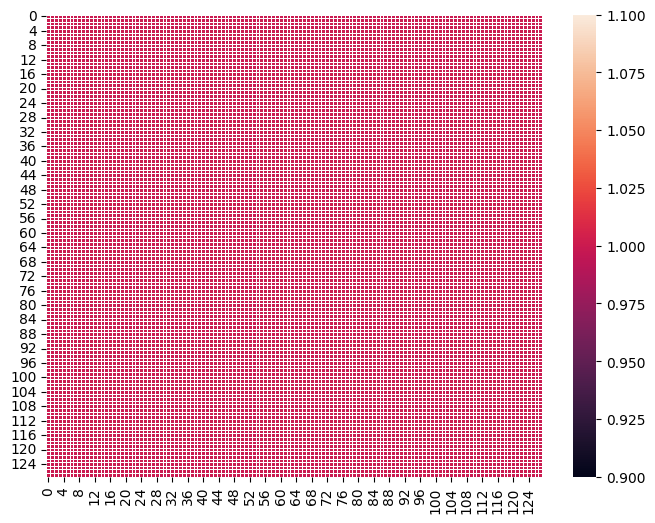

numpy.ndarray

In [23]:
M_linear = create_mask_linear(X_train[0], X_train[10], 12)
draw_matrix(M_linear)
type(M_linear)

In [12]:
M_non_linear = create_mask_non_linear(X_train[0], X_train[10])
draw_matrix(M_non_linear)

ValueError: not enough values to unpack (expected 2, got 1)

### 2.2. Two dimensional data

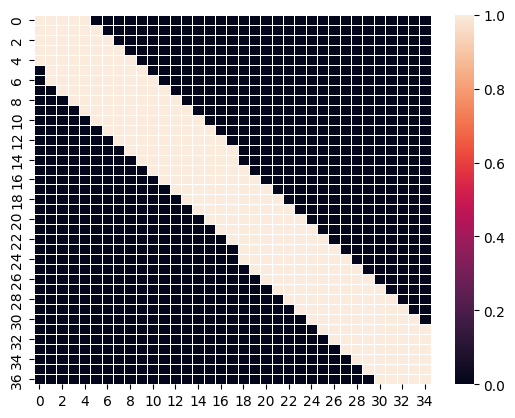

In [10]:
M_linear = create_mask_linear(X_train_arabic[0], X_train_arabic[760], 5)
draw_matrix(M_linear)

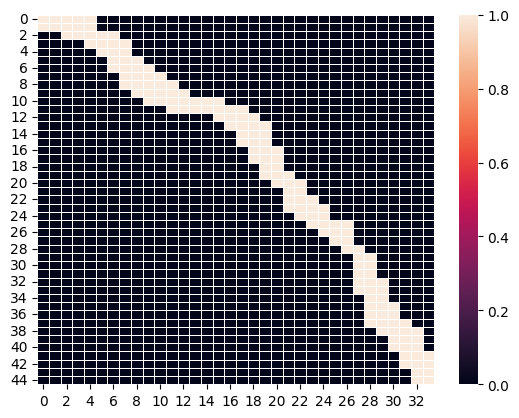

In [25]:
M_non_linear = create_mask_non_linear(X_train_arabic[2], X_test_arabic[395])
draw_matrix(M_non_linear)

## 3. Optimal matrix

In [1]:
from GetData.GetDataMultiDimensions import get_test_data, get_train_data
from GetData.GetDataOneDimension import getData
from MaskingMap.MaskingMapAutoWeighted import masking_map_auto_weighted
from MaskingMap.Utilities.utils import draw_matrix_aw
import os

X_train, y_train, X_test, y_test = getData('BME', '../Data/OneDimension/')
X_train_arabic, y_train_arabic = get_train_data(os.path.join('../Data/MultiDimensions/arabic/arabic/Train_Arabic_Digit.txt'))
X_test_arabic, y_test_arabic = get_test_data(os.path.join('../Data/MultiDimensions/arabic/arabic/Test_Arabic_Digit.txt'))

len(X_train), len(X_test), len(X_train_arabic), len(X_test_arabic)

(30, 150, 6600, 2200)

### 3.1. One dimensional data

In [2]:
y_train[0], y_test[70]

('1', '2')

In [3]:
y_train_arabic[0], y_test_arabic[700]

(0, 3)

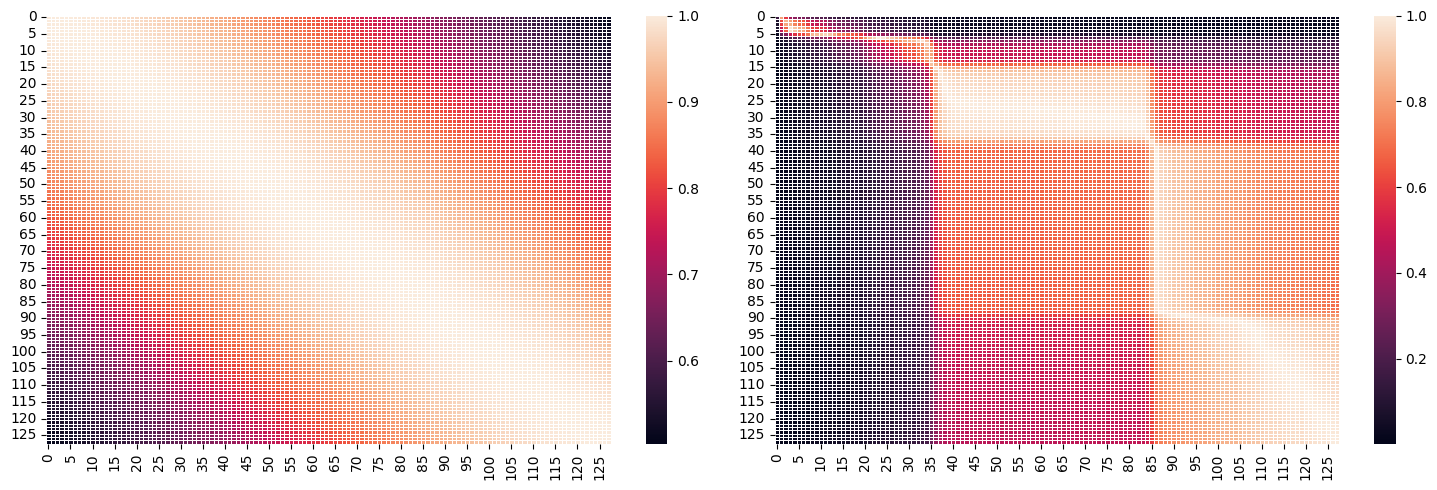

(None,
 array([[0.15560062, 0.80579002, 0.58424189, ..., 0.00789528, 0.00780666,
         0.00778846],
        [0.07806191, 0.62259548, 0.85868754, ..., 0.01573764, 0.015561  ,
         0.01552472],
        [0.07438217, 0.59324713, 0.81821011, ..., 0.01651619, 0.01633082,
         0.01629274],
        ...,
        [0.00121877, 0.00972053, 0.01340662, ..., 0.99207547, 0.99667473,
         0.99435101],
        [0.00121669, 0.0097039 , 0.01338368, ..., 0.99037789, 0.9983831 ,
         0.99605539],
        [0.00121189, 0.00966562, 0.01333089, ..., 0.98647124, 0.99766853,
         1.        ]]))

In [13]:
D1_cost = D1(X_train[0], X_test[70])
D2_cost = D2(X_train[0], X_test[70], type=1)
C = cost_matrix(X_train[0], X_test[70])
draw_multiple_matrices([D1_cost, D2_cost]), D2_cost

In [4]:
from MaskingMap.MaskingMapNonLinear import auto_weighted_masking_map

In [5]:
T, dis, iterations = auto_weighted_masking_map(X_train[0], X_test[70])
T, dis, iterations
# T, dis, w1, w2, iterations, draw_matrix(T)

(array([[0.00000000e+00, 7.81250000e-03, 7.81250000e-03, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.56805079e-05, 6.27052936e-05, 6.39016626e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.92194209e-05, 6.49283989e-05, 6.61281443e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         9.06360409e-05, 8.36201955e-05, 8.31534939e-05]]),
 0.8965566059466568,
 7)

In [7]:
T, dis, iterations = auto_weighted_masking_map(X_train_arabic[0], X_test_arabic[0])
T, dis, iterations

(array([[0.01126168, 0.0157646 , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.00289649, 0.00435799, 0.01063942, 0.00913251, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.00130235, 0.0020985 , 0.0056921 , 0.00517297, 0.00582042,
         0.00694021, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.

In [21]:
T, dis, w1, w2, iterations = auto_weighted_masking_map(X_train[0], X_test[70])
dis, iterations
# T, dis, w1, w2, iterations, draw_matrix(T)

(0.8965566059466568, 7)

In [24]:
T, dis, w1, w2, iterations = auto_weighted_masking_map(X_train_arabic[0], X_test_arabic[0])
dis, iterations

(0.9174968027514335, 4)

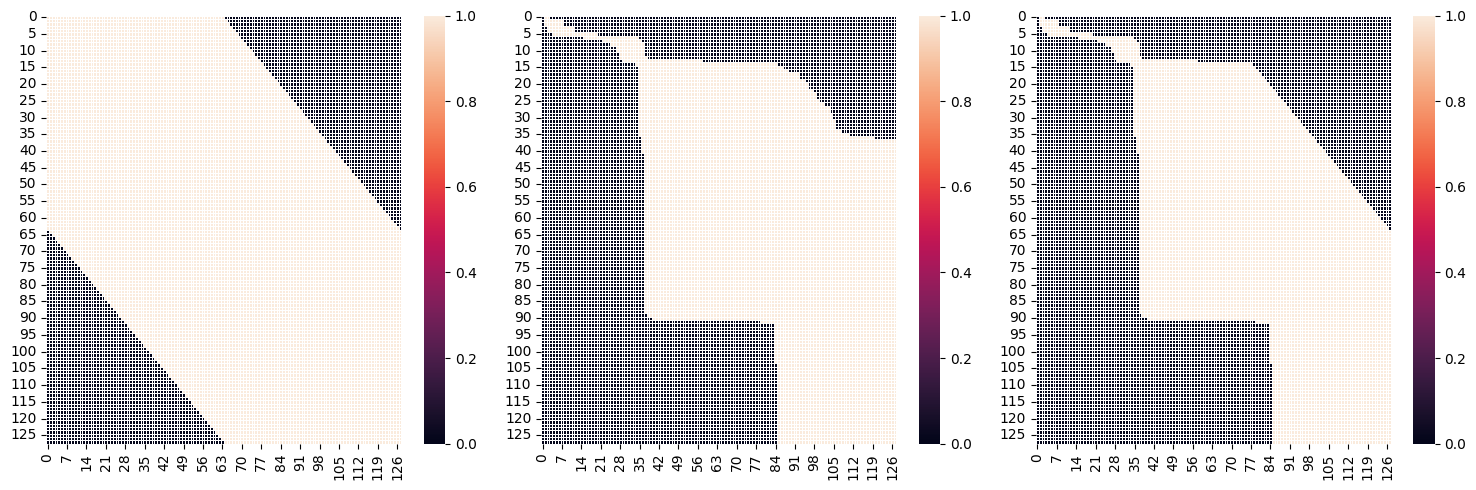

Iter: 1; w1: 0.512045686787493; w2: 0.579762365836655; M: [[0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]; cost 0.9194488396101199


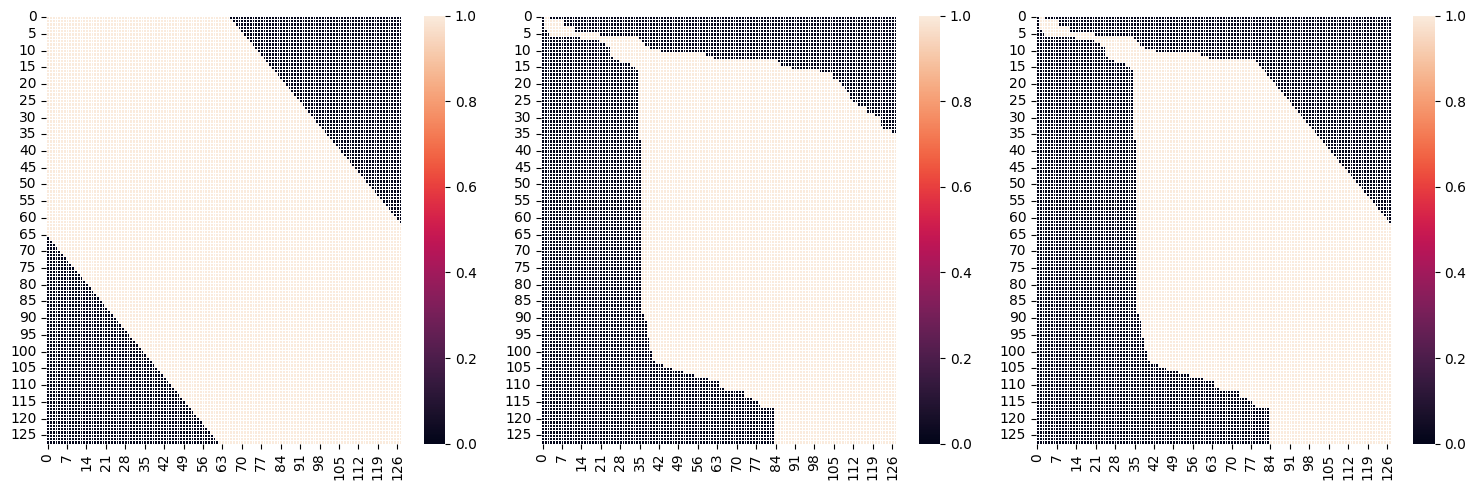

Iter: 2; w1: 0.518595405824772; w2: 0.6073381120288022; M: [[0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]; cost 0.8937037007724824


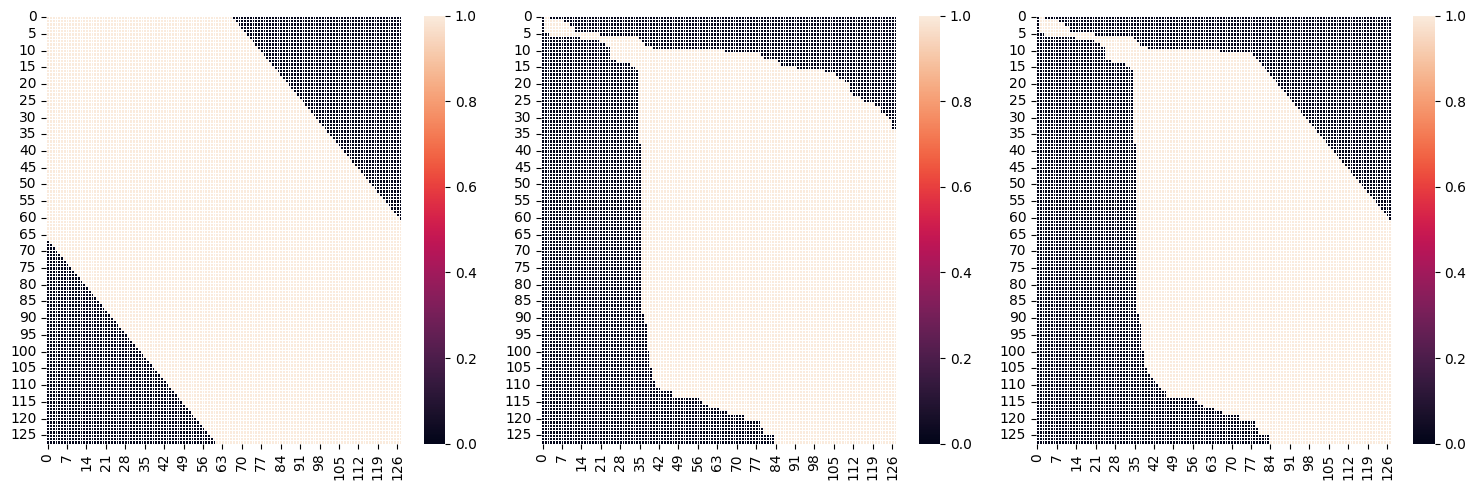

Iter: 3; w1: 0.5214604528645456; w2: 0.6145840093865075; M: [[0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]; cost 0.886201955251346


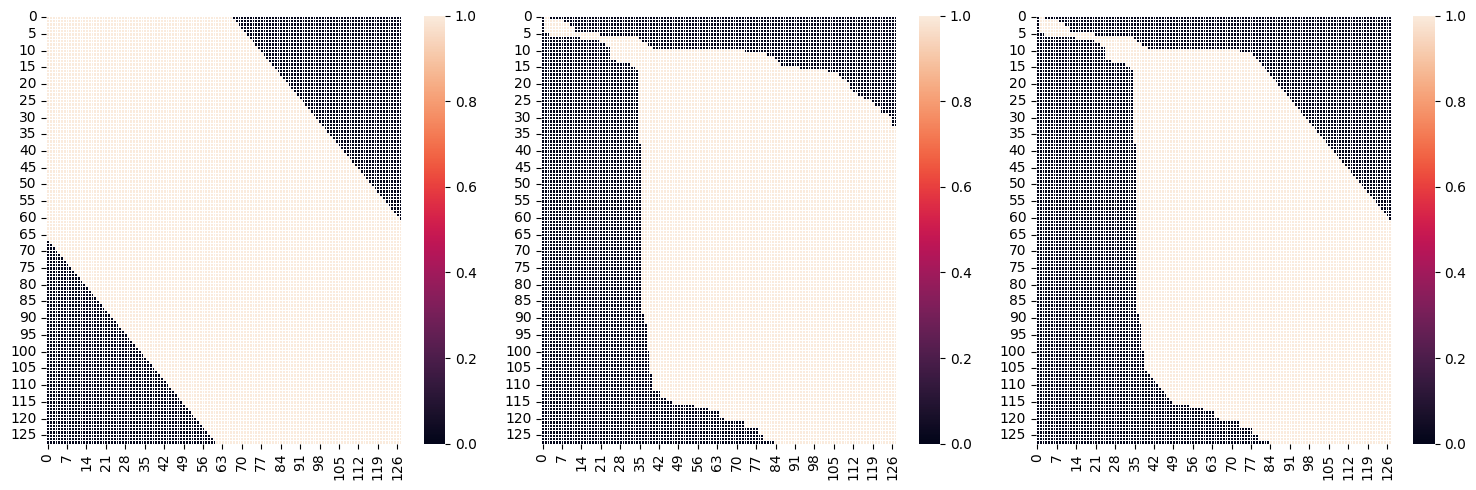

Iter: 4; w1: 0.5220892072492531; w2: 0.6160798661356127; M: [[0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]; cost 0.884636914558308


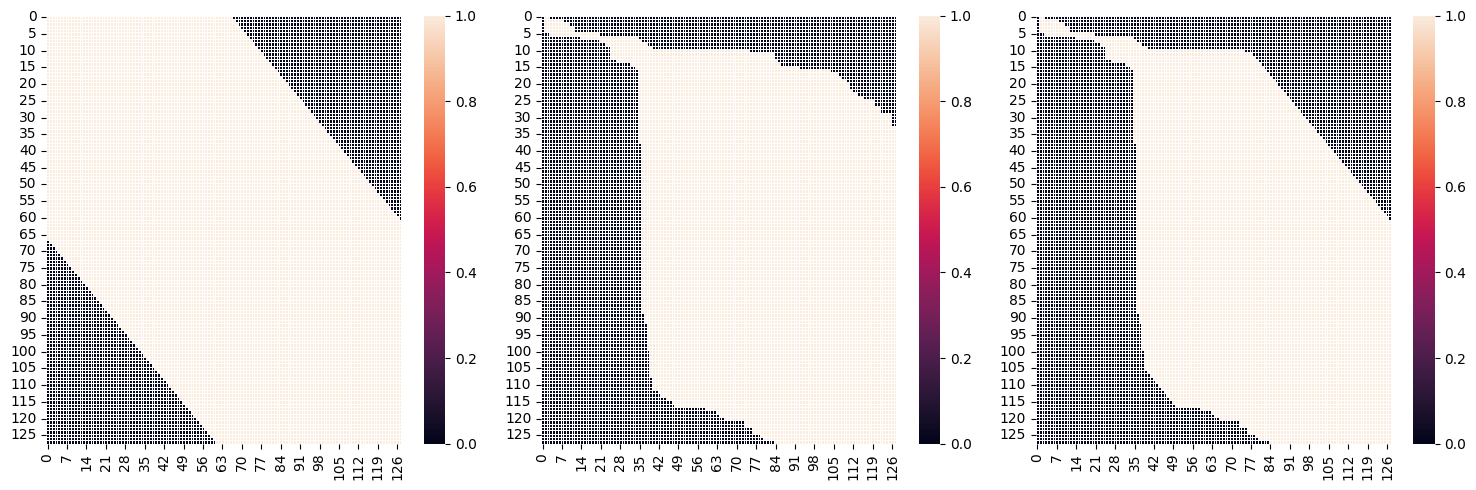

Iter: 5; w1: 0.5221882012089797; w2: 0.6163038524654352; M: [[0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]; cost 0.8843986585168828


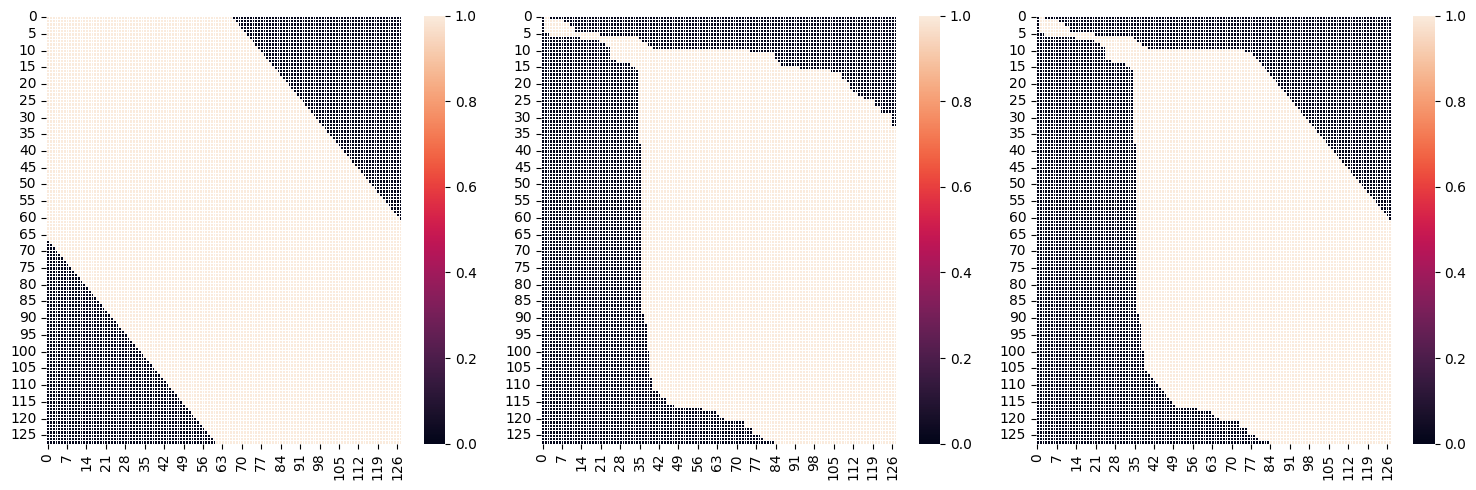

Iter: 6; w1: 0.5221952801062646; w2: 0.6163138853551963; M: [[0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]; cost 0.8843855650785871


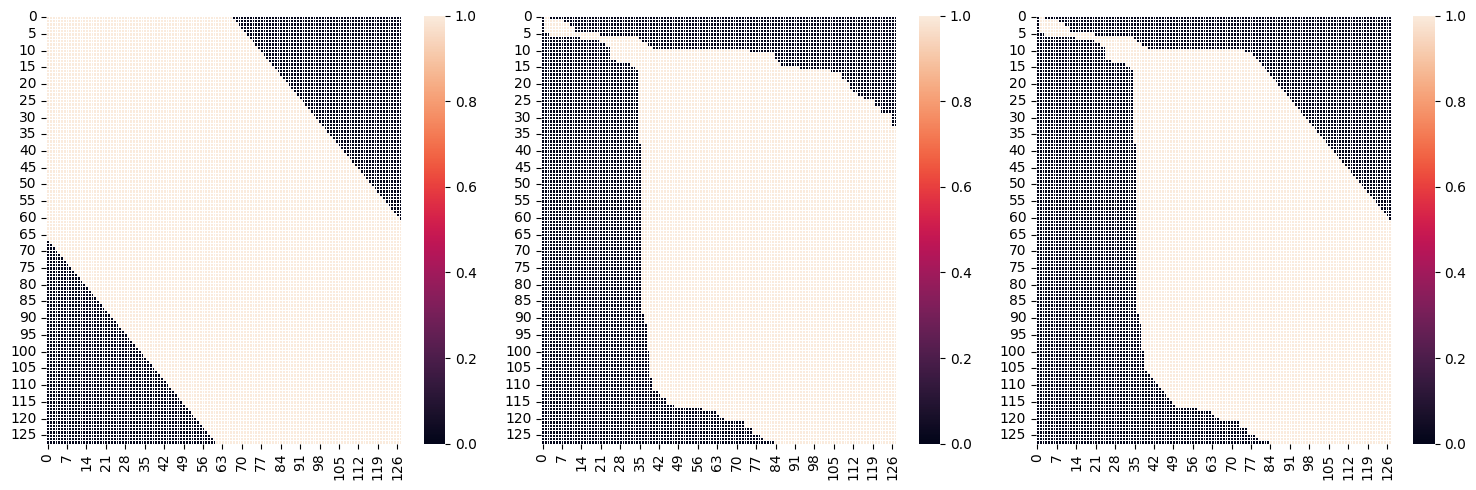

Iter: 7; w1: 0.5221952801062646; w2: 0.6163138853551963; M: [[0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]; cost 0.8843855650785871


In [26]:
T, dis, w1, w2, iterations = auto_weighted_masking_map(X_train[0], X_test[70])
# T, dis, w1, w2, iterations, draw_matrix(T)

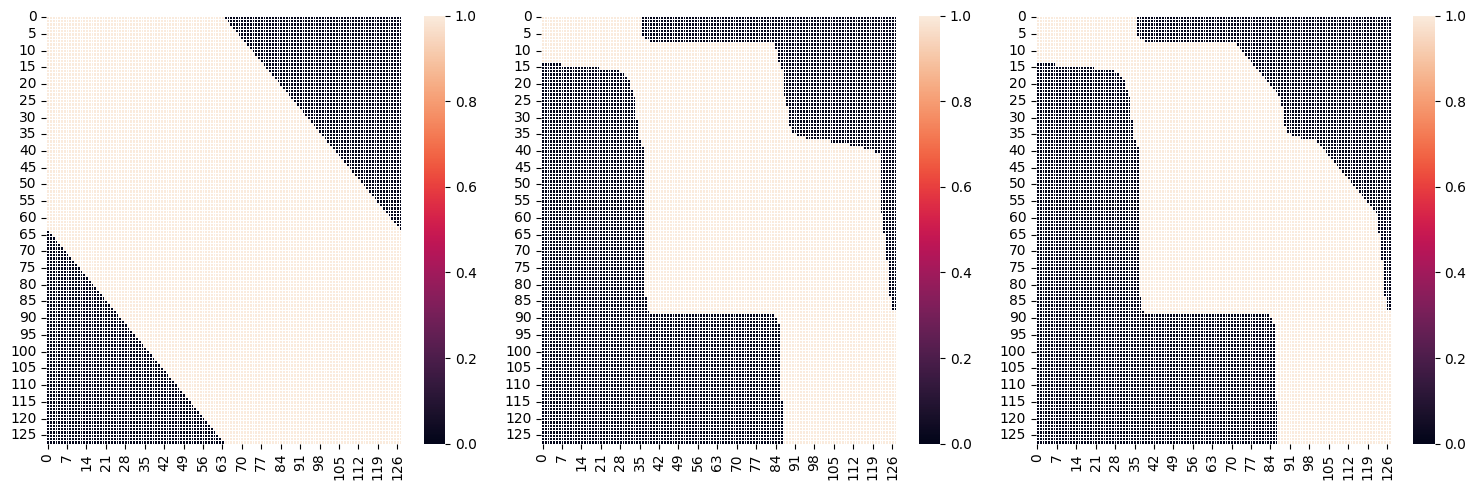

Iter: 1; w1: 0.5; w2: 0.5; M: [[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]; isTrue: (array([], dtype=int64), array([], dtype=int64)) 


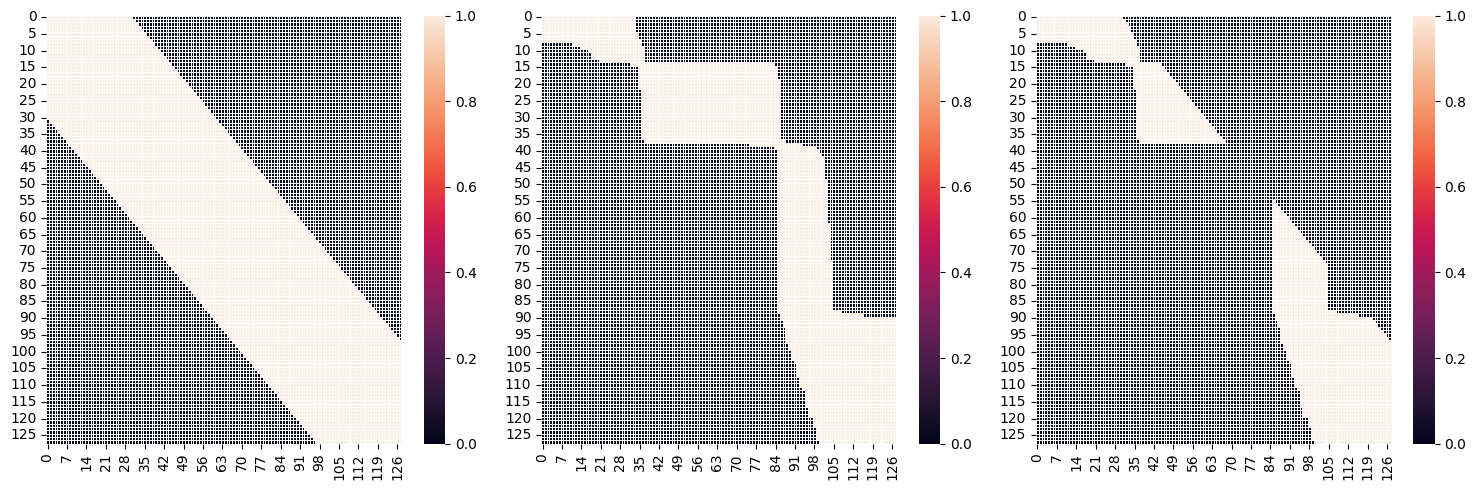

Iter: 2; w1: 0.7610025098901394; w2: 0.7610025098901394; M: [[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]; isTrue: (array([], dtype=int64), array([], dtype=int64)) 


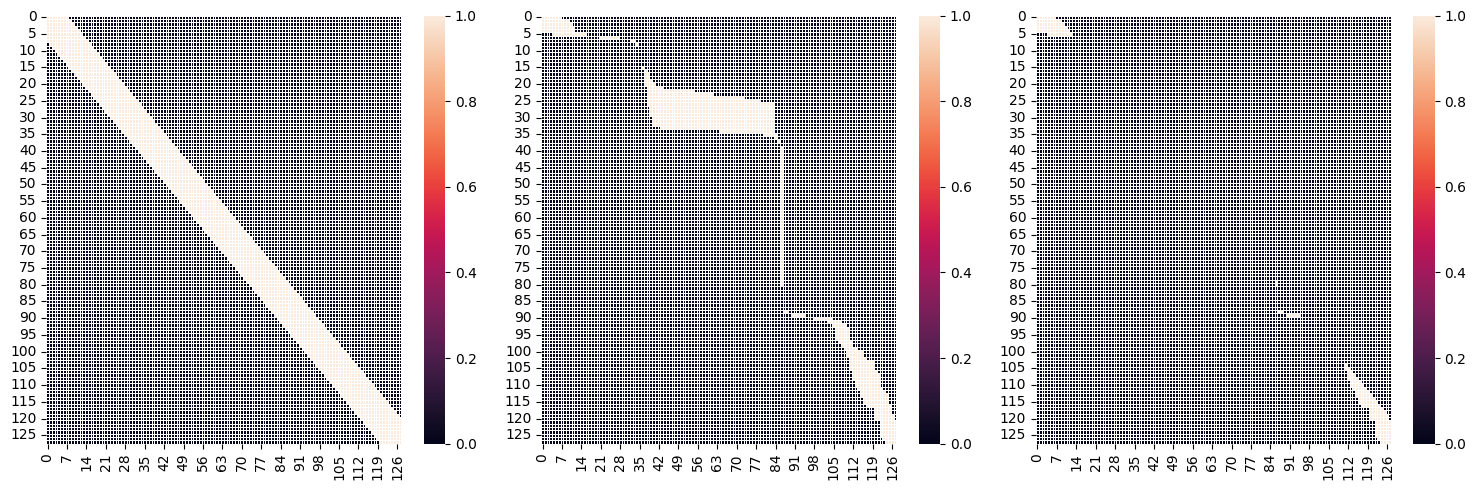

Iter: 3; w1: 0.9448430240118934; w2: 0.9448430240118934; M: [[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]; isTrue: (array([], dtype=int64), array([], dtype=int64)) 


IndexError: list index out of range

In [54]:
T, dis, w1, w2, iterations = auto_weighted_masking_map(X_train[0], X_test[70])
# T, dis, w1, w2, iterations, draw_matrix(T)

Iter 1: 1.3243780551015292; w1: 0.7550714058934919; w2: 3.667530439831481
Iter 2: 1.3243780551015292; w1: 0.7550714058934919; w2: 3.667530439831481


(array([[0.00147627, 0.00145794, 0.0010694 , ..., 0.        , 0.        ,
         0.        ],
        [0.00121341, 0.00122174, 0.00111575, ..., 0.        , 0.        ,
         0.        ],
        [0.00122104, 0.00122943, 0.00112277, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00044453, 0.00043068,
         0.00043   ],
        [0.        , 0.        , 0.        , ..., 0.00045978, 0.00044546,
         0.00044475],
        [0.        , 0.        , 0.        , ..., 0.00053841, 0.0005596 ,
         0.00055872]]),
 0.39926027384239005,
 0.7550714058934919,
 3.667530439831481,
 2,
 None)

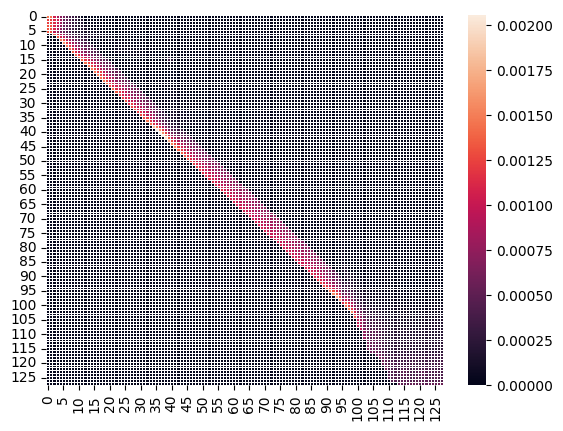

In [45]:
T, dis, w1, w2, iterations = auto_weighted_masking_map(X_train[0], X_train[10], lamb=5, ratio=0.1)
T, dis, w1, w2, iterations, draw_matrix(T)

Iter 1: 1.4504667313767983; w1: 0.6894332550811348; w2: 1.2224822481714437
Iter 2: 1.4504667313767983; w1: 0.6894332550811348; w2: 1.2224822481714437


(array([[0.00634521, 0.00458465, 0.00407504, ..., 0.        , 0.        ,
         0.        ],
        [0.00639523, 0.0046128 , 0.00392863, ..., 0.        , 0.        ,
         0.        ],
        [0.00657856, 0.00387275, 0.00343213, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00364515, 0.00454722,
         0.00510758],
        [0.        , 0.        , 0.        , ..., 0.00458668, 0.00568256,
         0.0071507 ],
        [0.        , 0.        , 0.        , ..., 0.00437389, 0.00602259,
         0.00922007]]),
 0.5671186299063703,
 0.6894332550811348,
 1.2224822481714437,
 2,
 None)

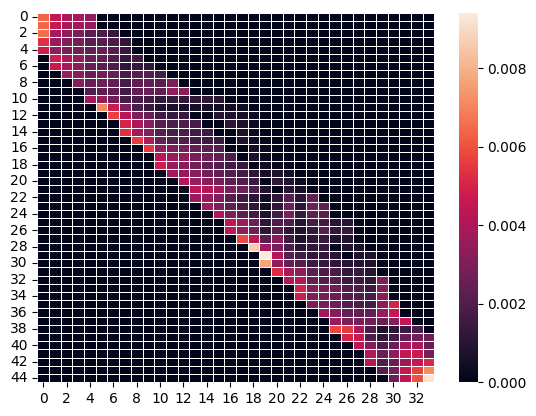

In [46]:
T, dis, w1, w2, iterations = auto_weighted_masking_map(X_train_arabic[2], X_test_arabic[395], lamb=5, ratio=0.1)
T, dis, w1, w2, iterations, draw_matrix(T)

### 3.2. Two dimensional data

Iter 1: 1.4504667313767983; w1: 0.6894332550811348; w2: 1.2224822481714437
Iter 2: 1.4504667313767983; w1: 0.6894332550811348; w2: 1.2224822481714437


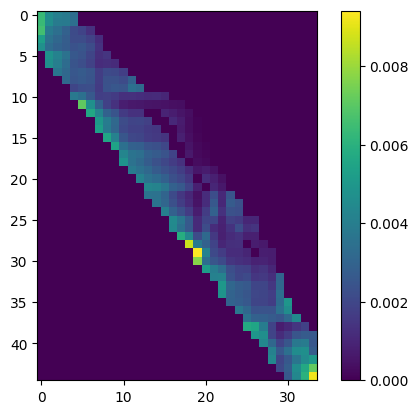

(array([[0.00634521, 0.00458465, 0.00407504, ..., 0.        , 0.        ,
         0.        ],
        [0.00639523, 0.0046128 , 0.00392863, ..., 0.        , 0.        ,
         0.        ],
        [0.00657856, 0.00387275, 0.00343213, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00364515, 0.00454722,
         0.00510758],
        [0.        , 0.        , 0.        , ..., 0.00458668, 0.00568256,
         0.0071507 ],
        [0.        , 0.        , 0.        , ..., 0.00437389, 0.00602259,
         0.00922007]]),
 0.5671186299063703,
 0.6894332550811348,
 1.2224822481714437,
 2,
 None)

In [49]:
T, dis, w1, w2, iterations = auto_weighted_masking_map(X_train_arabic[2], X_test_arabic[395], lamb=5, ratio=0.1, algorithm="sinkhorn")
T, dis, w1, w2, iterations, draw_matrix_aw(T, type="matplotlib")

In [42]:
T, dis, w1, w2, iterations = auto_weighted_masking_map(X_train_arabic[2], X_test_arabic[395], lamb=5, ratio=0.1)
T, dis, w1, w2, iterations

(array([[0.00634521, 0.00458465, 0.00407504, ..., 0.        , 0.        ,
         0.        ],
        [0.00639523, 0.0046128 , 0.00392863, ..., 0.        , 0.        ,
         0.        ],
        [0.00657856, 0.00387275, 0.00343213, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00364515, 0.00454722,
         0.00510758],
        [0.        , 0.        , 0.        , ..., 0.00458668, 0.00568256,
         0.0071507 ],
        [0.        , 0.        , 0.        , ..., 0.00437389, 0.00602259,
         0.00922007]]),
 0.5671186299063703,
 0.6894332550811348,
 1.2224822481714437,
 2)

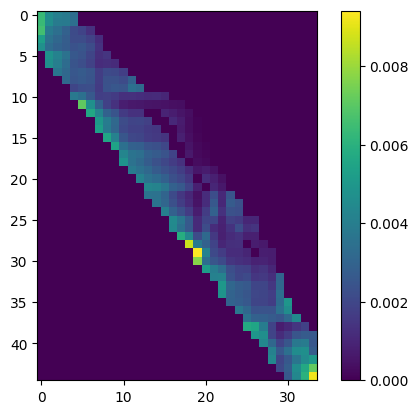

In [43]:
draw_matrix(T, type="matplotlib")

In [56]:
1/2

0.5